## #4

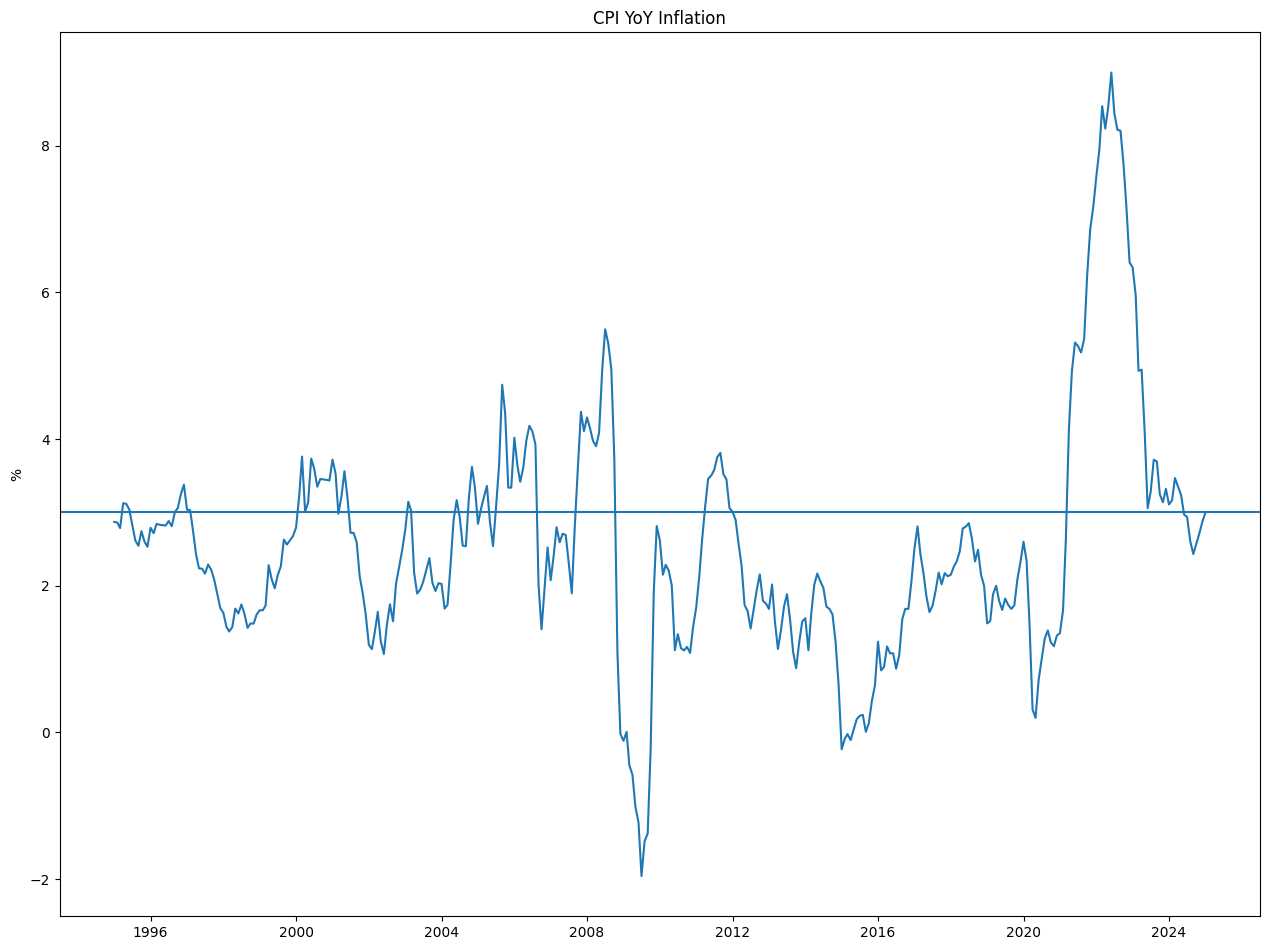

When CPI YoY inflation exceeds 3.0%, I would expect:
  • Nominal bond yields to rise (investors demand more compensation for eroding purchasing power), which drives bond prices down.
  • Commodity prices (e.g., oil, industrial metals) to climb, as higher consumer prices often reflect stronger underlying demand or cost‐push pressures.
  • Real returns on fixed‐income assets to fall, boosting interest in inflation‐protected securities (TIPS).


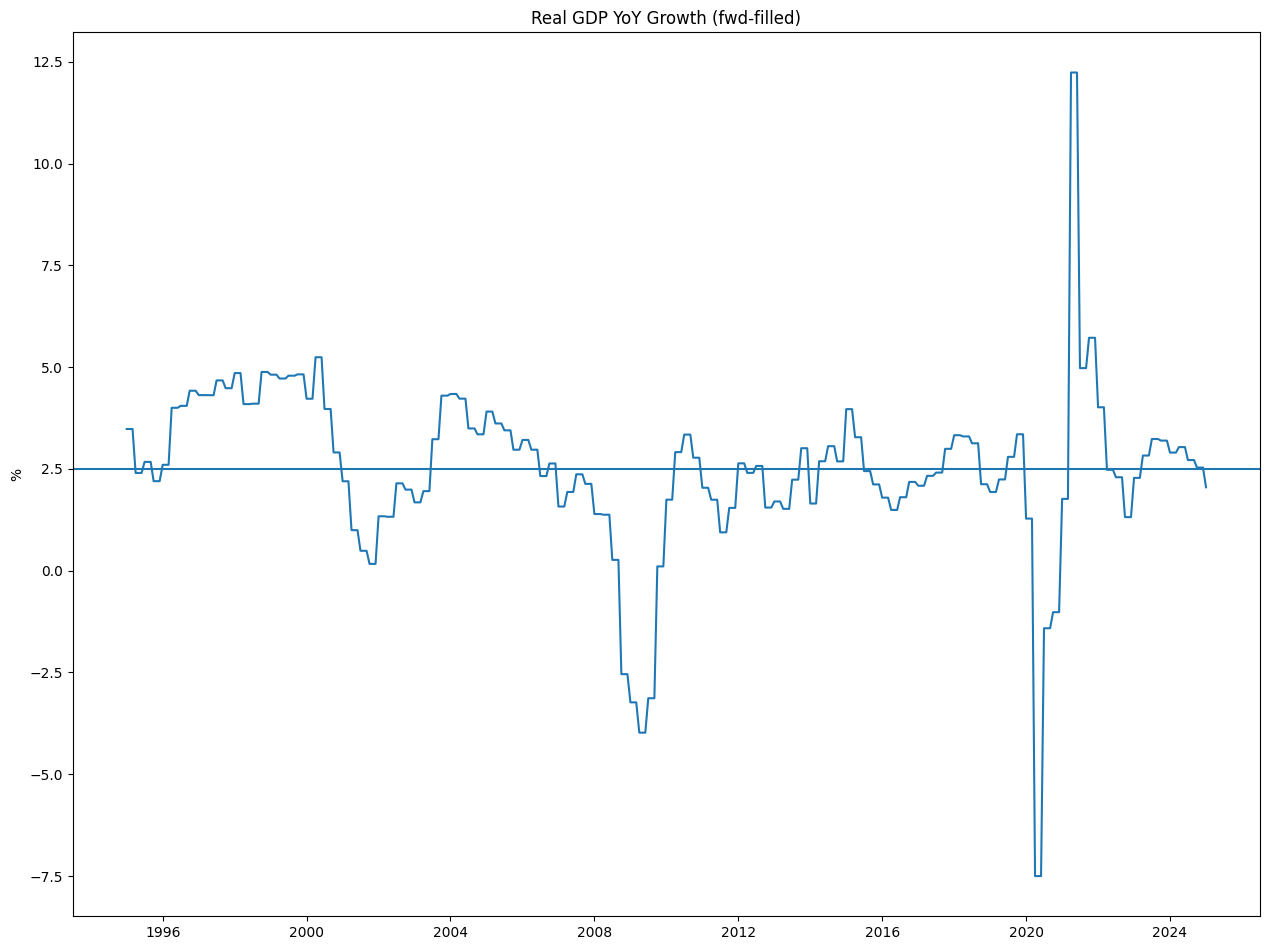

When real GDP YoY growth exceeds 2.5%, I would expect:
  • Equity prices to rise (stronger growth underpins higher corporate earnings), especially in cyclical sectors (e.g., industrials, consumer discretionary).
  • Credit spreads to tighten, as healthier economic conditions reduce default risk.
  • Risk‐seeking behavior to increase broadly, lifting high‐beta assets and emerging‐market equities.


In [5]:
import requests, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime

API_KEY = "cc91c0353502a330a6b90a1267bd4c96"

def fred(series, start="1994-01-01"):
    url = "https://api.stlouisfed.org/fred/series/observations"
    r = requests.get(url, params={
        "series_id": series,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start})
    r.raise_for_status()
    out = pd.DataFrame(r.json()["observations"])
    out["date"]  = pd.to_datetime(out["date"])
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    return out[["date", "value"]]

# ── 1. Pull the data ────────────────────────────────────────────────────────────
cpi = fred("CPIAUCSL")           # monthly
gdp = fred("GDPC1")              # quarterly (chained 2017 $)

# ── 2. Year‑over‑year % changes ────────────────────────────────────────────────
# ── 2. Year-over-year % changes ────────────────────────────────────────────────
cpi["inf_yoy"] = cpi["value"].pct_change(12) * 100
gdp["gdp_yoy"] = gdp["value"].pct_change(4) * 100

# forward-fill GDP **on month-start** so it lines up
gdp_m = (
    gdp.set_index("date")
       .resample("MS")     # <-- MS = month start
       .ffill()
       .reset_index()[["date","gdp_yoy"]]
)

df = (
    cpi[["date","inf_yoy"]]
      .merge(gdp_m, on="date", how="inner")
      .query("date >= '1995-01-01'")
      .copy()
)


# ── 3. Regime rules ────────────────────────────────────────────────────────────
INF_TH = 3.0   # %
GDP_TH = 2.5   # %

def tag(r):
    hi_inf = r.inf_yoy > INF_TH
    hi_gdp = r.gdp_yoy > GDP_TH
    if   hi_inf and hi_gdp:         return "Overheating"
    elif hi_inf and not hi_gdp:     return "Stagflation"
    elif not hi_inf and hi_gdp:     return "Goldilocks"
    else:                           return "Disinflationary slowdown"
df["regime"] = df.apply(tag, axis=1)

code = {"Goldilocks":0,"Overheating":1,"Disinflationary slowdown":2,"Stagflation":3}
df["regime_code"] = df.regime.map(code)

# ── 4. Charts (1 per figure, no color specs) ───────────────────────────────────




# Regime color map
regime_colors = {
    "Goldilocks": "green",
    "Overheating": "red",
    "Disinflationary slowdown": "blue",
    "Stagflation": "orange"
}

plt.figure(figsize=(12.8, 9.6))
plt.plot(df.date, df.inf_yoy)
plt.axhline(INF_TH)
plt.title("CPI YoY Inflation")
plt.ylabel("%")
plt.tight_layout()
plt.show()

print(
    f"When CPI YoY inflation exceeds {INF_TH}%, I would expect:\n"
    f"  • Nominal bond yields to rise (investors demand more compensation for eroding purchasing power), "
    "which drives bond prices down.\n"
    f"  • Commodity prices (e.g., oil, industrial metals) to climb, as higher consumer prices often reflect "
    "stronger underlying demand or cost‐push pressures.\n"
    f"  • Real returns on fixed‐income assets to fall, boosting interest in inflation‐protected securities (TIPS)."
)

plt.figure(figsize=(12.8, 9.6))
plt.plot(df.date, df.gdp_yoy)
plt.axhline(GDP_TH)
plt.title("Real GDP YoY Growth (fwd‑filled)")
plt.ylabel("%")
plt.tight_layout()
plt.show()

print(
    f"When real GDP YoY growth exceeds {GDP_TH}%, I would expect:\n"
    f"  • Equity prices to rise (stronger growth underpins higher corporate earnings), especially in cyclical sectors "
    "(e.g., industrials, consumer discretionary).\n"
    f"  • Credit spreads to tighten, as healthier economic conditions reduce default risk.\n"
    f"  • Risk‐seeking behavior to increase broadly, lifting high‐beta assets and emerging‐market equities."
)



## #5

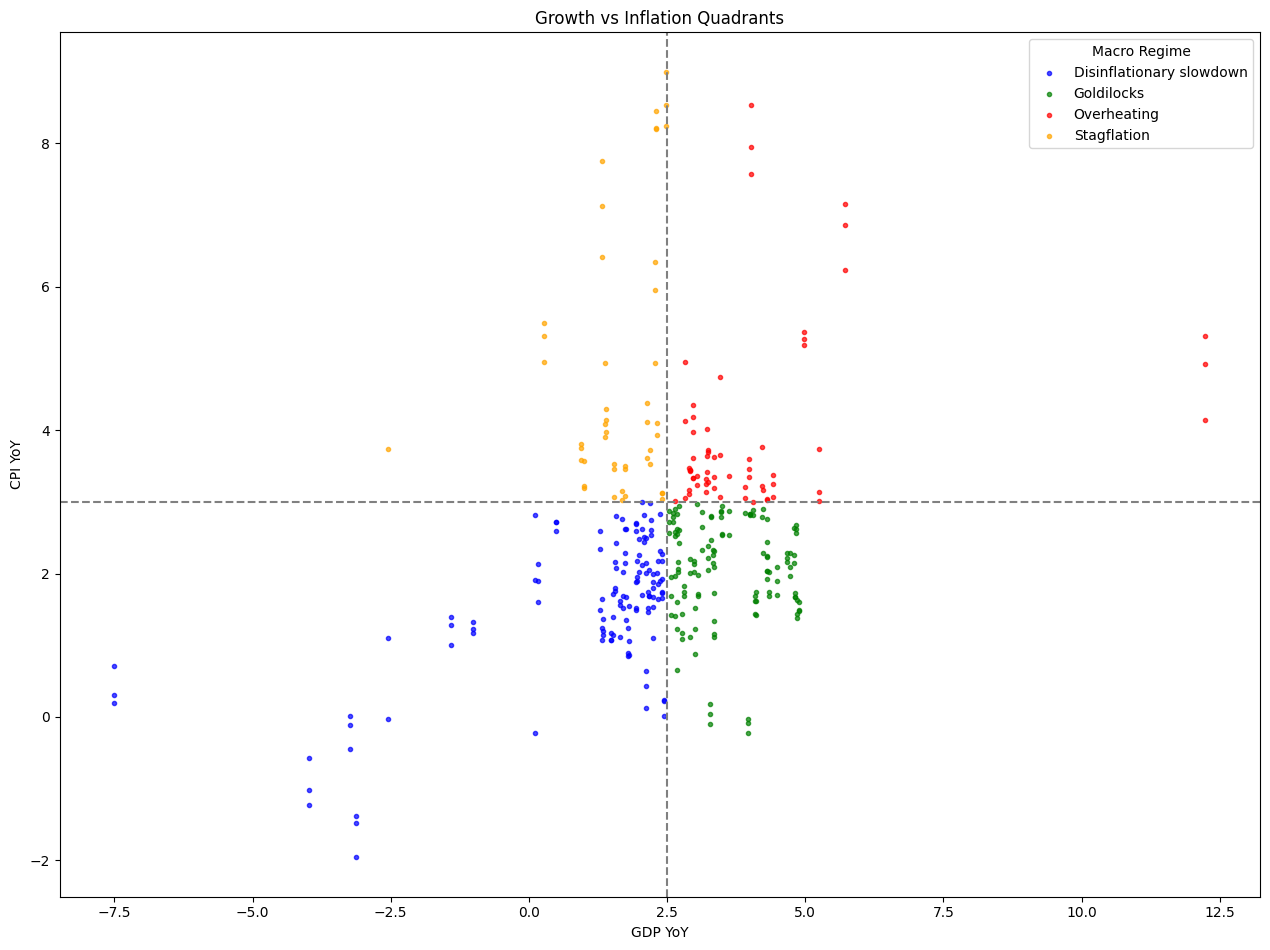

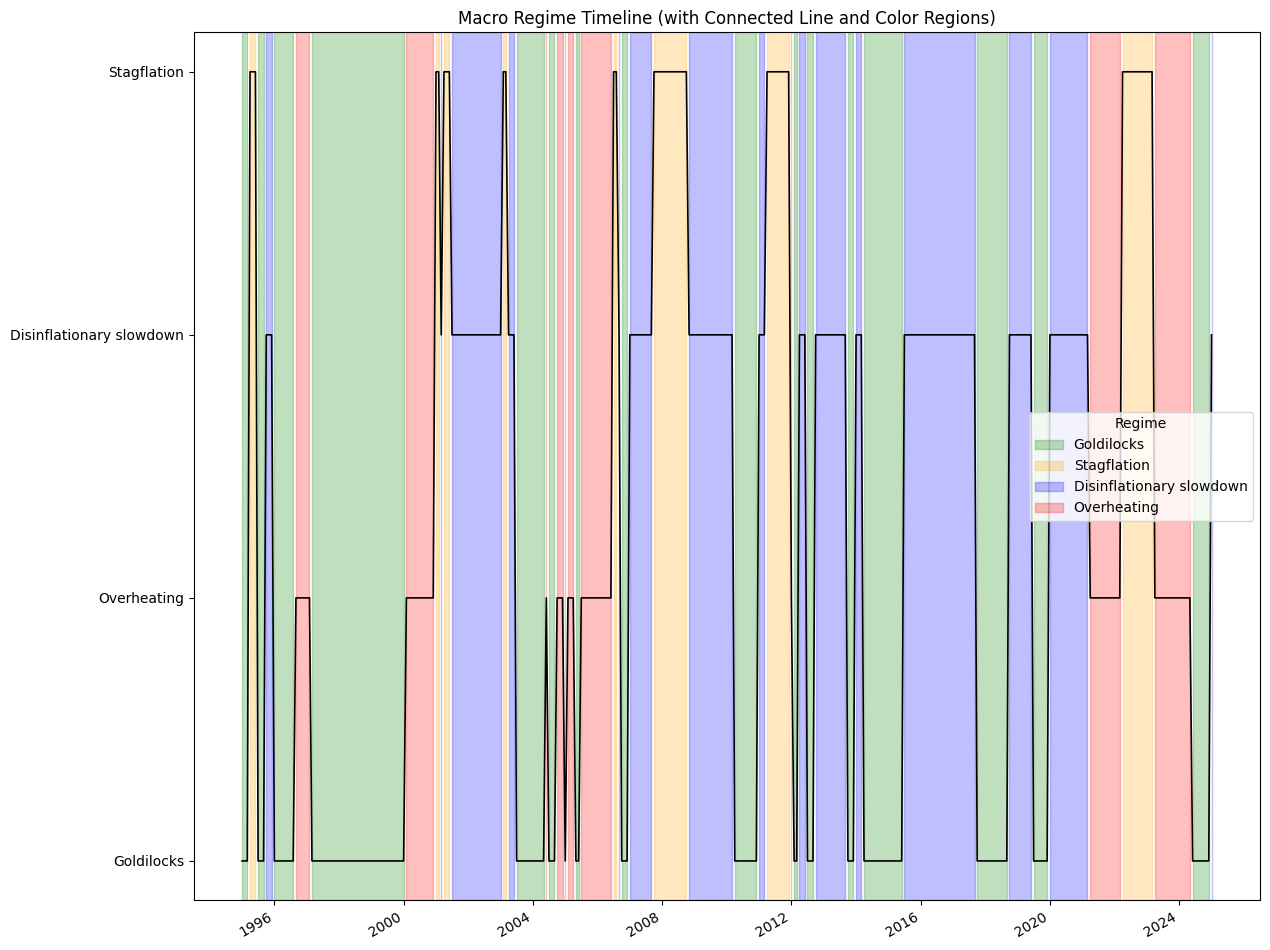

      date                   regime
1995-01-01               Goldilocks
1995-04-01              Stagflation
1995-07-01               Goldilocks
1995-10-01 Disinflationary slowdown
1996-01-01               Goldilocks
1996-09-01              Overheating
1997-03-01               Goldilocks
2000-02-01              Overheating
2001-01-01              Stagflation
2001-03-01 Disinflationary slowdown
2001-04-01              Stagflation
2001-07-01 Disinflationary slowdown
2003-02-01              Stagflation
2003-04-01 Disinflationary slowdown
2003-07-01               Goldilocks
2004-06-01              Overheating
2004-07-01               Goldilocks
2004-10-01              Overheating
2005-01-01               Goldilocks
2005-02-01              Overheating
2005-05-01               Goldilocks
2005-07-01              Overheating
2006-07-01              Stagflation
2006-09-01 Disinflationary slowdown
2006-10-01               Goldilocks
2007-01-01 Disinflationary slowdown
2007-10-01              Stag

In [6]:
# Quadrant chart with color-coded and labeled regimes
plt.figure(figsize=(12.8, 9.6))
for regime, group in df.groupby("regime"):
    plt.scatter(group.gdp_yoy, group.inf_yoy, 
                label=regime, 
                color=regime_colors[regime], 
                s=9, alpha=0.7)

plt.axvline(GDP_TH, linestyle="--", color="gray")
plt.axhline(INF_TH, linestyle="--", color="gray")
plt.title("Growth vs Inflation Quadrants")
plt.xlabel("GDP YoY")
plt.ylabel("CPI YoY")
plt.legend(title="Macro Regime")
plt.tight_layout()
plt.show()

# Regime timeline with color-coded spans
fig, ax = plt.subplots(figsize=(12.8, 9.6))
ax.plot(df["date"], df["regime_code"], color="black", linewidth=1.2)

for _, group in df.groupby((df["regime"] != df["regime"].shift()).cumsum()):
    regime_name = group["regime"].iloc[0]
    start_date = group["date"].iloc[0]
    end_date = group["date"].iloc[-1]
    ax.axvspan(start_date, end_date, 
               color=regime_colors[regime_name], alpha=0.25,
               label=regime_name if regime_name not in ax.get_legend_handles_labels()[1] else None)

ax.set_yticks(list(code.values()))
ax.set_yticklabels(list(code.keys()))
ax.set_title("Macro Regime Timeline (with Connected Line and Color Regions)")
ax.legend(title="Regime")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


# ── 5. Peek at the table ───────────────────────────────────────────────────────
df.head(10)[["date","inf_yoy","gdp_yoy","regime"]]




# pick out rows where the regime differs from the previous row
changes = df.loc[df.regime != df.regime.shift(1), ["date","regime"]]

# print them neatly
print(changes.to_string(index=False))